In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor


## Data preparation

### Read data from CSV

In [70]:
raw_data = pd.read_csv('../data/cleaned_movies.csv', delimiter=',')
raw_data.head()

,original_title,popularity,title,vote_average,vote_count,budget,imdb_id,production_companies,runtime,domestic_opening,...,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_Thriller,genre_War,genre_Western,domestic,international,worldwide
0,Venom: The Last Dance,3197.278,Venom: The Last Dance,6.500,759,120000000,tt16366836,"Columbia Pictures, Pascal Pictures, Matt Tolma...",109,51012404.0,...,False,False,False,True,False,False,False,128094490.0,308500000.0,4.365945e+08
1,Terrifier 3,2204.248,Terrifier 3,6.925,1012,2000000,tt27911000,"Cineverse, Bloody Disgusting, Dark Age Cinema,...",125,18928113.0,...,False,True,False,False,True,False,False,53981071.0,31395883.0,8.537695e+07
2,The Wild Robot,1868.856,The Wild Robot,8.500,2899,78000000,tt29623480,DreamWorks Animation,102,35790150.0,...,False,False,False,True,False,False,False,137913995.0,171143000.0,3.090570e+08
3,Deadpool & Wolverine,1490.952,Deadpool & Wolverine,7.700,5465,200000000,tt6263850,"Marvel Studios, Maximum Effort, 21 Laps Entert...",128,211435291.0,...,False,False,False,True,False,False,False,636745858.0,701154969.0,1.337901e+09
4,The Substance,1356.547,The Substance,7.273,2048,17500000,tt17526714,"Working Title Films, Blacksmith",141,3205212.0,...,False,False,False,True,False,False,False,16235191.0,35228181.0,5.146337e+07


### Remove unnecessary collumn and labeling

In [71]:
genre_columns = [col for col in raw_data.columns if col.startswith('genre_')]

for col in genre_columns:
    raw_data[col] = raw_data[col].astype(int)

numerical_data = raw_data.drop(columns=[
    'original_title',
    'title',
    'imdb_id',
    'production_companies',
    'domestic',
    'international'
])

numerical_data.head()




,popularity,vote_average,vote_count,budget,runtime,domestic_opening,asia_pacific_opening,europe_middle_east_and_africa_opening,years_from_release,genre_Action,...,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_Thriller,genre_War,genre_Western,worldwide
0,3197.278,6.500,759,120000000,109,51012404.0,12669884.0,27725511.0,0,1,...,0,0,0,0,0,1,0,0,0,4.365945e+08
1,2204.248,6.925,1012,2000000,125,18928113.0,1201876.0,10667946.0,0,0,...,0,1,0,1,0,0,1,0,0,8.537695e+07
2,1868.856,8.500,2899,78000000,102,35790150.0,4513231.0,16983417.0,0,0,...,0,0,0,0,0,1,0,0,0,3.090570e+08
3,1490.952,7.700,5465,200000000,128,211435291.0,54693311.0,76771204.0,0,1,...,0,0,0,0,0,1,0,0,0,1.337901e+09
4,1356.547,7.273,2048,17500000,141,3205212.0,871771.0,4017172.0,0,0,...,0,1,0,0,0,1,0,0,0,5.146337e+07


### Normalize revuene

In [72]:
numerical_data['worldwide'] = np.log1p(numerical_data['worldwide'])
numerical_data['budget'] = np.log1p(numerical_data['budget'])
# numerical_data['domestic'] = np.log1p(numerical_data['domestic'])
# numerical_data['international'] = np.log1p(numerical_data['international'])

### Split data into train, validation and test data set

In [73]:
train_data, valid_data, test_data = np.split(numerical_data.sample(frac=1, random_state=42), 
                                             [int(.6 * len(numerical_data)), 
                                              int(.8 * (len(numerical_data)))])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Review train, valid, test data

In [74]:
print("Train data shape: " + str(train_data.shape))
print("Valid data shape: " + str(valid_data.shape))
print("Test data shape: " + str(test_data.shape))

Train data shape: (685, 27)
Valid data shape: (229, 27)
Test data shape: (229, 27)


### Split data into X and y

In [75]:
X_train = train_data[train_data.columns[:-1]]
y_train = train_data[train_data.columns[-1]]

X_valid = valid_data[valid_data.columns[:-1]]
y_valid = valid_data[valid_data.columns[-1]]

X_test = test_data[test_data.columns[:-1]]
y_test = test_data[test_data.columns[-1]]

## Building predicting models

### Linear regression model

Training Results:
R2 Score: 0.7113
MSE: 0.5117
MAE: 0.5022

Validation Results:
R2 Score: 0.6941
MSE: 0.5134
MAE: 0.5039

Test Results:
R2 Score: 0.6447
MSE: 0.6655
MAE: 0.5536


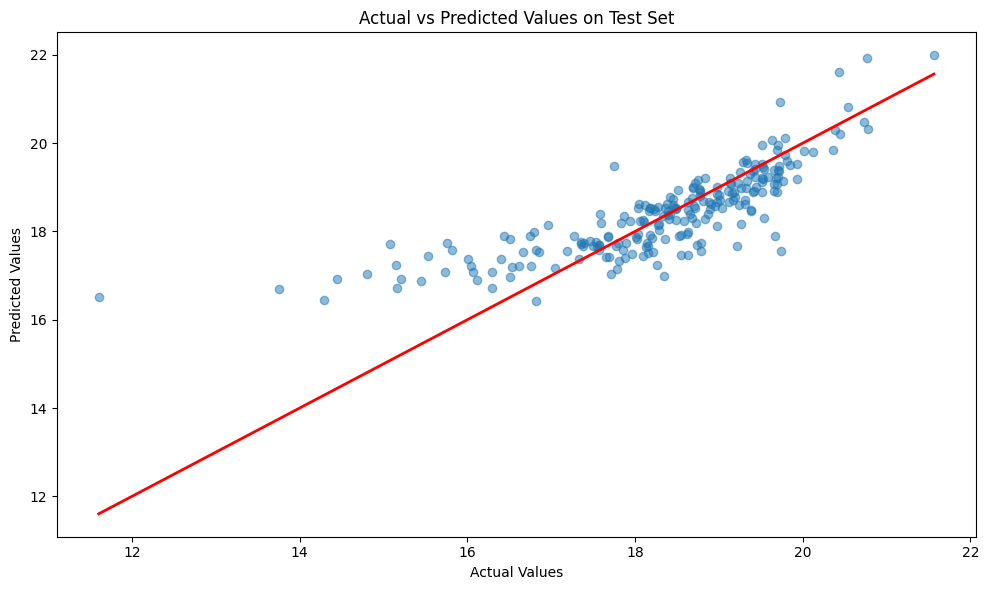

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_valid = lr_model.predict(X_valid)
y_pred_test = lr_model.predict(X_test)
train_r2 = r2_score(y_train, y_pred_train)
valid_r2 = r2_score(y_valid, y_pred_valid)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
valid_mse = mean_squared_error(y_valid, y_pred_valid)
train_mae = mean_absolute_error(y_train, y_pred_train)
valid_mae = mean_absolute_error(y_valid, y_pred_valid)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")

print("\nValidation Results:")
print(f"R2 Score: {valid_r2:.4f}")
print(f"MSE: {valid_mse:.4f}")
print(f"MAE: {valid_mae:.4f}")
print("\nTest Results:")

print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

### Random Forest Regressor

Training Results:
R2 Score: 0.9824
MSE: 0.0311
MAE: 0.1106

Validation Results:
R2 Score: 0.8950
MSE: 0.1763
MAE: 0.2828

Test Results:
R2 Score: 0.8359
MSE: 0.3073
MAE: 0.3243


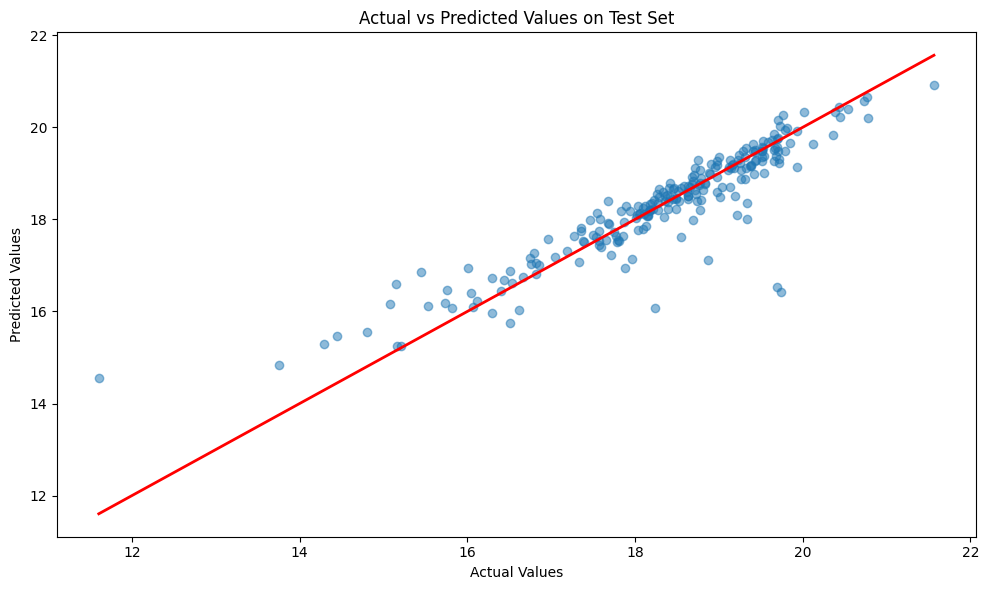

In [77]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_valid = rf_model.predict(X_valid)
y_pred_test = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
valid_r2 = r2_score(y_valid, y_pred_valid)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
valid_mse = mean_squared_error(y_valid, y_pred_valid)
train_mae = mean_absolute_error(y_train, y_pred_train)
valid_mae = mean_absolute_error(y_valid, y_pred_valid)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nValidation Results:")
print(f"R2 Score: {valid_r2:.4f}")
print(f"MSE: {valid_mse:.4f}")
print(f"MAE: {valid_mae:.4f}")
print("\nTest Results:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()



### SVR

Training Results:
R2 Score: 0.8033
MSE: 0.3486
MAE: 0.3659

Validation Results:
R2 Score: 0.8249
MSE: 0.2939
MAE: 0.3624

Test Results:
R2 Score: 0.7152
MSE: 0.5334
MAE: 0.4300


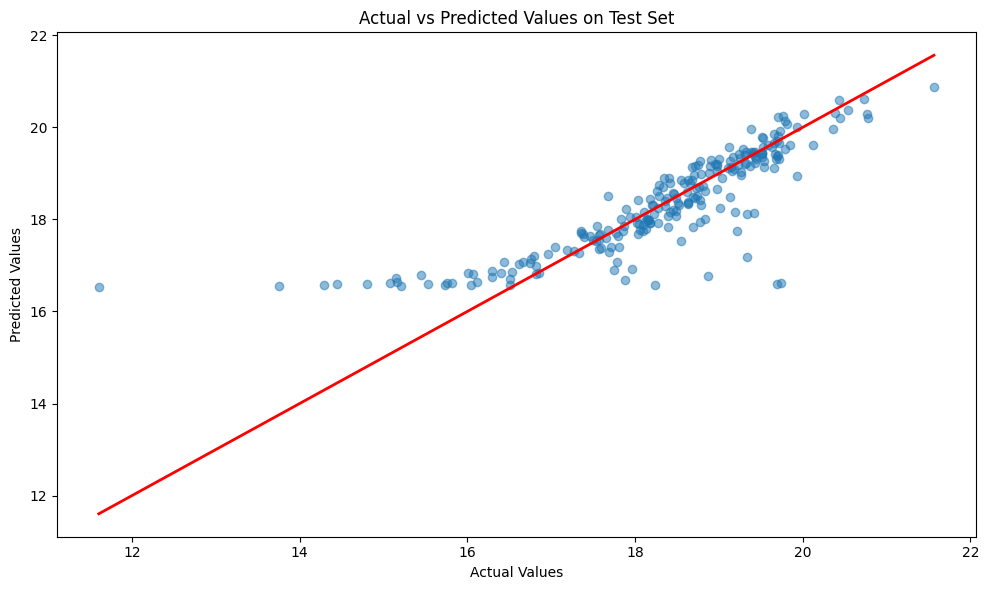

In [78]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_train = svr_model.predict(X_train)
y_pred_valid = svr_model.predict(X_valid)
y_pred_test = svr_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
valid_r2 = r2_score(y_valid, y_pred_valid)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
valid_mse = mean_squared_error(y_valid, y_pred_valid)
train_mae = mean_absolute_error(y_train, y_pred_train)

valid_mae = mean_absolute_error(y_valid, y_pred_valid)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nValidation Results:")
print(f"R2 Score: {valid_r2:.4f}")
print(f"MSE: {valid_mse:.4f}")
print(f"MAE: {valid_mae:.4f}")
print("\nTest Results:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

### Create pipeline


In [79]:
# Create a pipeline with StandardScaler and a placeholder for the regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', None)  # Placeholder for the model
])

### Hyperparameter Tuning with GridSearchCV and Validation Set

In [80]:
# Define the parameter grid for each model
param_grid = [
    {
        'regressor': [LinearRegression()],
    },
    {
        'regressor': [SVR(kernel='rbf')],
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (negative MSE):", grid_search.best_score_)

Best parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best cross-validation score (negative MSE): -0.22016512756242385


### Model Evaluation on Validation Set

In [81]:
# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred_valid = best_model.predict(X_valid)

# Evaluate the model on the validation set
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
r2_valid = r2_score(y_valid, y_pred_valid)

print("Best Model Validation - RMSE:", rmse_valid)
print("Best Model Validation - R-squared:", r2_valid)

Best Model Validation - RMSE: 0.41976333599700927
Best Model Validation - R-squared: 0.8950157958285349


### Model Evaluation on Test Set

In [82]:
# Make predictions on the test set
y_pred_test = best_model.predict(X_test)

# Evaluate the model on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Best Model Test - RMSE:", rmse_test)
print("Best Model Test - R-squared:", r2_test)

Best Model Test - RMSE: 0.5545203447212533
Best Model Test - R-squared: 0.8358235823975095


### Visualization

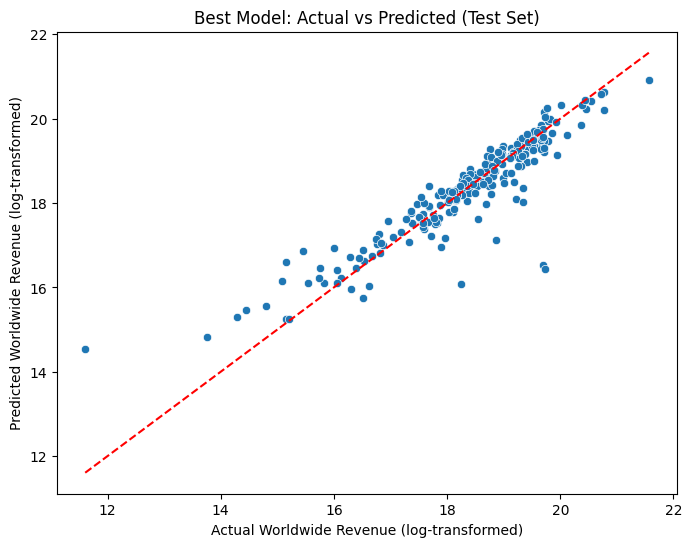

In [83]:
# Visualize actual vs predicted values for the test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Diagonal line
plt.title('Best Model: Actual vs Predicted (Test Set)')
plt.xlabel('Actual Worldwide Revenue (log-transformed)')
plt.ylabel('Predicted Worldwide Revenue (log-transformed)')
plt.show()